
# SSVEP Decoding

This notebook runs only the data analysis part of experiment.

Look at the notes to see how this can be run on the web with binder or google collab.

All of the additional notes are removed; only the code cells are kept.


## Setup



In [1]:
# Some standard pythonic imports
import warnings
warnings.filterwarnings('ignore')
import os,numpy as np,pandas as pd
from collections import OrderedDict
import seaborn as sns
from matplotlib import pyplot as plt

# MNE functions
from mne import Epochs,find_events
from mne.decoding import Vectorizer

# EEG-Notebooks functions
from eegnb.analysis.analysis_utils import load_data
from eegnb.datasets import fetch_dataset

# Scikit-learn and Pyriemann ML functionalities
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from pyriemann.estimation import Covariances, ERPCovariances, XdawnCovariances, Xdawn
from pyriemann.spatialfilters import CSP
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM

## One subject, One session

### Load Data

In [ ]:
current_dir = os.getcwd()
base_dir = os.path.abspath(os.path.join(current_dir, '..'))
eegnb_data_path = os.path.join(base_dir, 'data')
ssvep_data_path = os.path.join(eegnb_data_path, 'visual-SSVEP', 'eegnb_examples')

# If dataset hasn't been downloaded yet, download it 
if not os.path.isdir(ssvep_data_path):
    fetch_dataset(data_dir=eegnb_data_path, experiment='visual-SSVEP', site='eegnb_examples')        

subject = 1
session = 1
raw = load_data(subject, session, 
                experiment='visual-SSVEP', site='eegnb_examples', device_name='muse2016',
                data_dir = eegnb_data_path,
                replace_ch_names={'Right AUX': 'POz'})

events = find_events(raw)
event_id = {'30 Hz': 1, '20 Hz': 2}
epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-0.5, tmax=4, baseline=None, preload=True,
                verbose=False, picks=[0, 1, 2, 3, 4])
print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)



Loading these files: 

e:\CSE\Semester 7\CS4681 - Advanced Machine Learning\Lab\Research Paper\.eegnb\data\visual-SSVEP\eegnb_examples\muse2016\subject0001\session001\data_2017-09-14-21.20.04.csv

e:\CSE\Semester 7\CS4681 - Advanced Machine Learning\Lab\Research Paper\.eegnb\data\visual-SSVEP\eegnb_examples\muse2016\subject0001\session001\data_2017-09-14-21.22.51.csv

e:\CSE\Semester 7\CS4681 - Advanced Machine Learning\Lab\Research Paper\.eegnb\data\visual-SSVEP\eegnb_examples\muse2016\subject0001\session001\data_2017-09-14-21.25.17.csv

e:\CSE\Semester 7\CS4681 - Advanced Machine Learning\Lab\Research Paper\.eegnb\data\visual-SSVEP\eegnb_examples\muse2016\subject0001\session001\data_2017-09-14-21.27.36.csv

e:\CSE\Semester 7\CS4681 - Advanced Machine Learning\Lab\Research Paper\.eegnb\data\visual-SSVEP\eegnb_examples\muse2016\subject0001\session001\data_2017-09-14-21.29.57.csv

e:\CSE\Semester 7\CS4681 - Advanced Machine Learning\Lab\Research Paper\.eegnb\data\visual-SSVEP\eegnb_ex

### Decoding


In [3]:
# We can use a filter bank approach on the original 4 Muse electrodes (to see how the headband alone without external electrodes could be used to classify SSVEP):

#    - Apply bandpass filters around both stimulation frequencies
#    - Concatenate bandpass-filtered channels
#    - Extract epochs (from 1 to 3 s after stimulus onset, to avoid classifying the ERP)
#    - Apply common classification pipelines

# Bandpass filter the raw data
muse_raw = raw.drop_channels(['POz'])
raw_filt_30Hz = muse_raw.copy().filter(25, 35, method='iir')
raw_filt_20Hz = muse_raw.copy().filter(15, 25, method='iir')
raw_filt_30Hz.rename_channels(lambda x: x + '_30Hz')
raw_filt_20Hz.rename_channels(lambda x: x + '_20Hz')

# Concatenate with the bandpass filtered channels
raw_all = raw_filt_30Hz.add_channels([raw_filt_20Hz], 
                                            force_update_info=True)

# Extract epochs
events = find_events(raw_all)
event_id = {'30 Hz': 1, '20 Hz': 2}

epochs_all = Epochs(raw_all, events=events, event_id=event_id, 
                    tmin=1, tmax=3, baseline=None, 
                    reject={'eeg': 100e-6}, preload=True, verbose=False,)

epochs_all.pick_types(eeg=True)
X = epochs_all.get_data() * 1e6
times = epochs.times
y = epochs_all.events[:, -1]

Filtering raw data in 6 contiguous segments


Setting up band-pass filter from 25 - 35 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 25.00, 35.00 Hz: -6.02, -6.02 dB

Filtering raw data in 6 contiguous segments
Setting up band-pass filter from 15 - 25 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 15.00, 25.00 Hz: -6.02, -6.02 dB

Finding events on: stim_30Hz, stim_20Hz
197 events found on stim channel stim_30Hz
Event IDs: [1 2]
197 events found on stim channel stim_20Hz
Event IDs: [1 2]
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


### Classification



CSP + RegLDA
CSP + RegLDA lsqr
CSP + RegLDA Tuned
Cov + TS
Cov + TS Tuned
Cov + MDM
CSP + Cov + TS
CSP + Cov + TS Tuned
CSP + TS + LR
Cov + TS + SVM
Xdawn + TS + LR


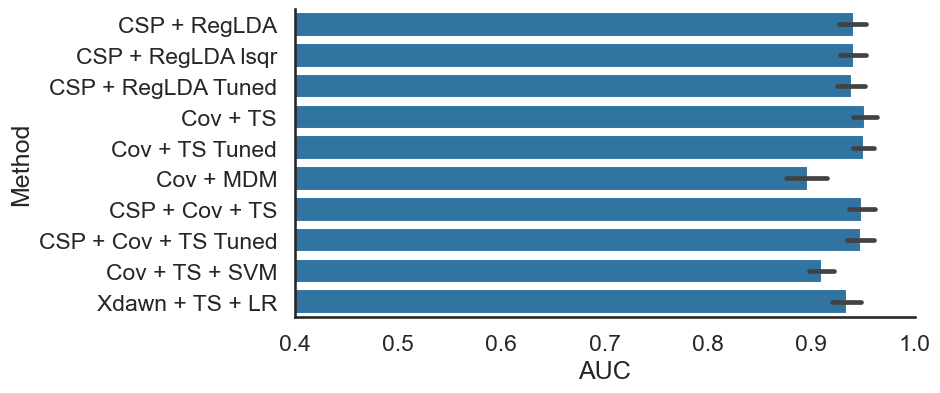

In [4]:
# Next, we will use 4 different machine learning pipelines to classify the SSVEP based on the data we collected. The

# - CSP + RegLDA : Common Spatial Patterns + Regularized Linear Discriminat Analysis. This is a very common EEG analysis pipeline.
# - Cov + TS : Covariance + Tangent space mapping. One of the most reliable Riemannian geometry-based pipelines.
# - Cov + MDM: Covariance + MDM. A very simple, yet effective (for low channel count), Riemannian geometry classifier.
# - CSP + Cov + TS: Common Spatial Patterns + Covariance + Tangent spacem mapping. Riemannian pipeline with the standard CSP procedure beforehand

# Evaluation is done through cross-validation, with area-under-the-curve (AUC) as metric (AUC is probably the best metric for binary and unbalanced classification problem)

# Note: because we're doing machine learning here, the following cell may take a while to complete

clfs = OrderedDict()
clfs['CSP + RegLDA'] = make_pipeline(Covariances(), CSP(4), LDA(shrinkage='auto', solver='eigen'))
clfs['CSP + RegLDA lsqr'] = make_pipeline(Covariances(), CSP(4), LDA(shrinkage='auto', solver='lsqr'))
clfs['CSP + RegLDA Tuned'] = make_pipeline(Covariances(), CSP(8, log=True), LDA(shrinkage='auto', solver='eigen'))
clfs['Cov + TS'] = make_pipeline(Covariances(), TangentSpace(), LogisticRegression())
clfs['Cov + TS Tuned'] = make_pipeline(Covariances(), TangentSpace(), LogisticRegression(C=0.5, penalty='l2', solver='lbfgs', max_iter=500))
clfs['Cov + MDM'] = make_pipeline(Covariances(), MDM())
clfs['CSP + Cov + TS'] = make_pipeline(Covariances(), CSP(4, log=False), TangentSpace(), LogisticRegression())
clfs['CSP + Cov + TS Tuned'] = make_pipeline(Covariances(), CSP(4, log=False), TangentSpace(), LogisticRegression(C=0.5, penalty='l2', solver='lbfgs', max_iter=500))
clfs['CSP + TS + LR'] = make_pipeline(CSP(6), TangentSpace(), StandardScaler(), LogisticRegression(C=0.7))
clfs['Cov + TS + SVM'] = make_pipeline(Covariances(), TangentSpace(), StandardScaler(), SVC(kernel='rbf', C=1))
clfs['Xdawn + TS + LR'] = make_pipeline(XdawnCovariances(nfilter=4), TangentSpace(), StandardScaler(), LogisticRegression())

# define cross validation 
cv = StratifiedShuffleSplit(n_splits=20, test_size=0.25, 
                                        random_state=42)

# run cross validation for each pipeline
auc = []
methods = []
for m in clfs:
    print(m)     
    try:    
        res = cross_val_score(clfs[m], X, y==2, scoring='roc_auc',cv=cv, n_jobs=-1)
        auc.extend(res)
        methods.extend([m]*len(res))
    except:
        pass
    
results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

fig = plt.figure(figsize=(8, 4))
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.4, 1)
sns.despine()

In [5]:
# Create DataFrame
results_auc = pd.DataFrame({'AUC': auc, 'Method': methods})

# Function to print summary with max possible AUC
def print_summary_with_max(df, metric_name):
    print(f"\n{metric_name} summary:")
    summary = df.groupby('Method')[metric_name].agg(['mean','std']).round(3)
    # Add max possible column (mean + std, capped at 1)
    summary['max_possible'] = (summary['mean'] + summary['std']).clip(upper=1.0)
    print(summary)

# Print summary
print_summary_with_max(results_auc, 'AUC')


AUC summary:
                       mean    std  max_possible
Method                                          
CSP + Cov + TS        0.949  0.030         0.979
CSP + Cov + TS Tuned  0.948  0.029         0.977
CSP + RegLDA          0.941  0.030         0.971
CSP + RegLDA Tuned    0.940  0.034         0.974
CSP + RegLDA lsqr     0.941  0.030         0.971
Cov + MDM             0.896  0.048         0.944
Cov + TS              0.952  0.026         0.978
Cov + TS + SVM        0.910  0.030         0.940
Cov + TS Tuned        0.951  0.025         0.976
Xdawn + TS + LR       0.935  0.033         0.968


## All subjects, All sessions

### Load Data

In [ ]:
from mne import concatenate_epochs

current_dir = os.getcwd()
base_dir = os.path.abspath(os.path.join(current_dir, '..'))
eegnb_data_path = os.path.join(base_dir, 'data')
ssvep_data_path = os.path.join(eegnb_data_path, 'visual-SSVEP', 'eegnb_examples')

# Download dataset if missing
if not os.path.isdir(ssvep_data_path):
    fetch_dataset(data_dir=eegnb_data_path, experiment='visual-SSVEP', site='eegnb_examples')

# Subject → available session mapping
sub_sess = {
    1: [1],
    3: [1, 2, 3],
    4: [1]
}

event_id = {'30 Hz': 1, '20 Hz': 2}
all_epochs = []
all_epochs_dec = []

# Load only listed subjects/sessions
for subj, sessions in sub_sess.items():
    for sess in sessions:
        try:
            print(f"Loading Subject {subj}, Session {sess}...")
            raw = load_data(subj, sess,
                experiment='visual-SSVEP',
                site='eegnb_examples',
                device_name='muse2016',
                data_dir=eegnb_data_path,
                replace_ch_names={'Right AUX': 'POz'}
            )
            events = find_events(raw)
            temp_epochs = Epochs(
                raw, events=events, event_id=event_id,
                tmin=-0.5, tmax=4, baseline=None, preload=True,
                verbose=False, picks=[0,1,2,3,4])
            print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)
            all_epochs.append(temp_epochs)
            print(f"Loaded Subject {subj}, Session {sess} — {len(temp_epochs)} epochs")
            # Bandpass filter the raw data
            muse_raw = raw.drop_channels(['POz'])
            raw_filt_30Hz = muse_raw.copy().filter(25, 35, method='iir')
            raw_filt_20Hz = muse_raw.copy().filter(15, 25, method='iir')
            raw_filt_30Hz.rename_channels(lambda x: x + '_30Hz')
            raw_filt_20Hz.rename_channels(lambda x: x + '_20Hz')

            # Concatenate with the bandpass filtered channels
            raw_all = raw_filt_30Hz.add_channels([raw_filt_20Hz], 
                                                        force_update_info=True)

            # Extract epochs
            events = find_events(raw_all)
            event_id = {'30 Hz': 1, '20 Hz': 2}

            temp_epochs_all = Epochs(raw_all, events=events, event_id=event_id, 
                                tmin=1, tmax=3, baseline=None, 
                                reject={'eeg': 100e-6}, preload=True, verbose=False,)
            all_epochs_dec.append(temp_epochs_all)

        except Exception as e:
            print(f"Skipping Subject {subj}, Session {sess}: {e}")

# Concatenate all loaded epochs
if all_epochs:
    all_epochs = concatenate_epochs(all_epochs)
    all_epochs_dec = concatenate_epochs(all_epochs_dec)
    print(f"\nTotal combined epochs: {len(all_epochs)}")
    print(f"\nTotal combined epochs: {len(all_epochs_dec)}")
else:
    raise RuntimeError("No valid epochs found — check subject/session availability.")

Loading Subject 1, Session 1...


Loading these files: 

e:\CSE\Semester 7\CS4681 - Advanced Machine Learning\Lab\Research Paper\.eegnb\data\visual-SSVEP\eegnb_examples\muse2016\subject0001\session001\data_2017-09-14-21.20.04.csv

e:\CSE\Semester 7\CS4681 - Advanced Machine Learning\Lab\Research Paper\.eegnb\data\visual-SSVEP\eegnb_examples\muse2016\subject0001\session001\data_2017-09-14-21.22.51.csv

e:\CSE\Semester 7\CS4681 - Advanced Machine Learning\Lab\Research Paper\.eegnb\data\visual-SSVEP\eegnb_examples\muse2016\subject0001\session001\data_2017-09-14-21.25.17.csv

e:\CSE\Semester 7\CS4681 - Advanced Machine Learning\Lab\Research Paper\.eegnb\data\visual-SSVEP\eegnb_examples\muse2016\subject0001\session001\data_2017-09-14-21.27.36.csv

e:\CSE\Semester 7\CS4681 - Advanced Machine Learning\Lab\Research Paper\.eegnb\data\visual-SSVEP\eegnb_examples\muse2016\subject0001\session001\data_2017-09-14-21.29.57.csv

e:\CSE\Semester 7\CS4681 - Advanced Machine Learning\Lab\Research Paper\.

### Decoding

In [9]:
# We can use a filter bank approach on the original 4 Muse electrodes (to see how the headband alone without external electrodes could be used to classify SSVEP):

#    - Apply bandpass filters around both stimulation frequencies
#    - Concatenate bandpass-filtered channels
#    - Extract epochs (from 1 to 3 s after stimulus onset, to avoid classifying the ERP)
#    - Apply common classification pipelines

# Bandpass filter the raw data
# muse_raw = raw.drop_channels(['POz'])
# raw_filt_30Hz = muse_raw.copy().filter(25, 35, method='iir')
# raw_filt_20Hz = muse_raw.copy().filter(15, 25, method='iir')
# raw_filt_30Hz.rename_channels(lambda x: x + '_30Hz')
# raw_filt_20Hz.rename_channels(lambda x: x + '_20Hz')

# # Concatenate with the bandpass filtered channels
# raw_all = raw_filt_30Hz.add_channels([raw_filt_20Hz], 
#                                             force_update_info=True)

# # Extract epochs
# events = find_events(raw_all)
# event_id = {'30 Hz': 1, '20 Hz': 2}

# epochs_all = Epochs(raw_all, events=events, event_id=event_id, 
#                     tmin=1, tmax=3, baseline=None, 
#                     reject={'eeg': 100e-6}, preload=True, verbose=False,)

all_epochs_dec.pick_types(eeg=True)
X = all_epochs_dec.get_data() * 1e6
times = all_epochs.times
y = all_epochs_dec.events[:, -1]

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


### Classification

CSP + RegLDA
CSP + RegLDA lsqr
CSP + RegLDA Tuned
Cov + TS
Cov + TS Tuned
Cov + MDM
CSP + Cov + TS
CSP + Cov + TS Tuned
CSP + TS + LR
Cov + TS + SVM
Xdawn + TS + LR


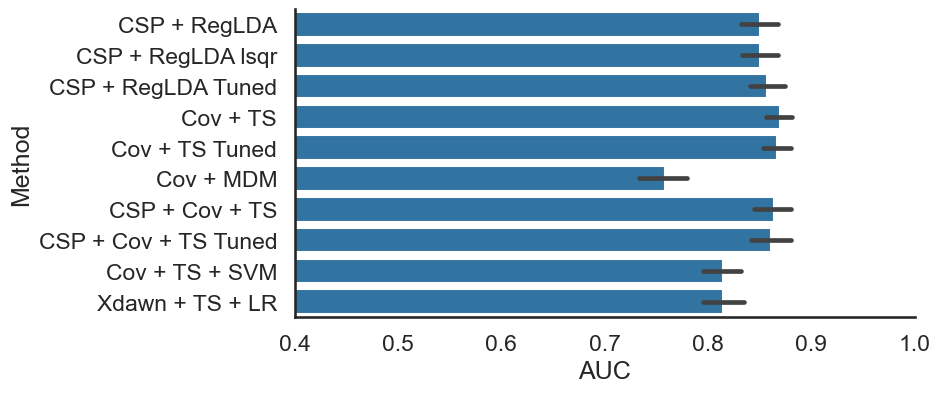

In [10]:
# Next, we will use 4 different machine learning pipelines to classify the SSVEP based on the data we collected. The

# - CSP + RegLDA : Common Spatial Patterns + Regularized Linear Discriminat Analysis. This is a very common EEG analysis pipeline.
# - Cov + TS : Covariance + Tangent space mapping. One of the most reliable Riemannian geometry-based pipelines.
# - Cov + MDM: Covariance + MDM. A very simple, yet effective (for low channel count), Riemannian geometry classifier.
# - CSP + Cov + TS: Common Spatial Patterns + Covariance + Tangent spacem mapping. Riemannian pipeline with the standard CSP procedure beforehand

# Evaluation is done through cross-validation, with area-under-the-curve (AUC) as metric (AUC is probably the best metric for binary and unbalanced classification problem)

# Note: because we're doing machine learning here, the following cell may take a while to complete

clfs = OrderedDict()
clfs['CSP + RegLDA'] = make_pipeline(Covariances(), CSP(4), LDA(shrinkage='auto', solver='eigen'))
clfs['CSP + RegLDA lsqr'] = make_pipeline(Covariances(), CSP(4), LDA(shrinkage='auto', solver='lsqr'))
clfs['CSP + RegLDA Tuned'] = make_pipeline(Covariances(), CSP(8, log=True), LDA(shrinkage='auto', solver='eigen'))
clfs['Cov + TS'] = make_pipeline(Covariances(), TangentSpace(), LogisticRegression())
clfs['Cov + TS Tuned'] = make_pipeline(Covariances(), TangentSpace(), LogisticRegression(C=0.5, penalty='l2', solver='lbfgs', max_iter=500))
clfs['Cov + MDM'] = make_pipeline(Covariances(), MDM())
clfs['CSP + Cov + TS'] = make_pipeline(Covariances(), CSP(4, log=False), TangentSpace(), LogisticRegression())
clfs['CSP + Cov + TS Tuned'] = make_pipeline(Covariances(), CSP(4, log=False), TangentSpace(), LogisticRegression(C=0.5, penalty='l2', solver='lbfgs', max_iter=500))
clfs['CSP + TS + LR'] = make_pipeline(CSP(6), TangentSpace(), StandardScaler(), LogisticRegression(C=0.7))
clfs['Cov + TS + SVM'] = make_pipeline(Covariances(), TangentSpace(), StandardScaler(), SVC(kernel='rbf', C=1))
clfs['Xdawn + TS + LR'] = make_pipeline(XdawnCovariances(nfilter=4), TangentSpace(), StandardScaler(), LogisticRegression())

# define cross validation 
cv = StratifiedShuffleSplit(n_splits=20, test_size=0.25, 
                                        random_state=42)

# run cross validation for each pipeline
auc = []
methods = []
for m in clfs:
    print(m)     
    try:    
        res = cross_val_score(clfs[m], X, y==2, scoring='roc_auc',cv=cv, n_jobs=-1)
        auc.extend(res)
        methods.extend([m]*len(res))
    except:
        pass
    
results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

fig = plt.figure(figsize=(8, 4))
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.4, 1)
sns.despine()

In [11]:
# Create DataFrame
results_auc = pd.DataFrame({'AUC': auc, 'Method': methods})

# Function to print summary with max possible AUC
def print_summary_with_max(df, metric_name):
    print(f"\n{metric_name} summary:")
    summary = df.groupby('Method')[metric_name].agg(['mean','std']).round(3)
    # Add max possible column (mean + std, capped at 1)
    summary['max_possible'] = (summary['mean'] + summary['std']).clip(upper=1.0)
    print(summary)

# Print summary
print_summary_with_max(results_auc, 'AUC')


AUC summary:
                       mean    std  max_possible
Method                                          
CSP + Cov + TS        0.864  0.045         0.909
CSP + Cov + TS Tuned  0.861  0.047         0.908
CSP + RegLDA          0.850  0.042         0.892
CSP + RegLDA Tuned    0.858  0.040         0.898
CSP + RegLDA lsqr     0.850  0.042         0.892
Cov + MDM             0.758  0.057         0.815
Cov + TS              0.869  0.030         0.899
Cov + TS + SVM        0.814  0.040         0.854
Cov + TS Tuned        0.867  0.034         0.901
Xdawn + TS + LR       0.815  0.048         0.863
